In [1]:
import os
import re
from datetime import datetime


from dateutil import parser
from sklearn.impute import SimpleImputer
import statsmodels.stats.multitest as stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy

## preprocessing

In [2]:
df = pd.read_csv('../data/storm_results_continuous_ES.csv', sep=',')

print(df.shape)
df.head()

(329, 16)


,site,ISA,karst_features,sinkholes,forest_cover,developed_open_space,Watershed_area_km2,q_peak_cfs,lagtime_lambert_minutes,bf_peak,Area_norm_baseflow_atPeakQ,Bfmin,total_storm_baseflow,date_storm,nest,notes
0,Lower_DC,31.95,145,145,2.19,21.59,94.534635,879.0,114.0,0.286436,7.540000e-08,0.255642,0.393710,4/13/2018 20:45,Deer_creek,NaN
1,Lower_DC,31.95,145,145,2.19,21.59,94.534635,25.8,1014.0,0.926702,7.160000e-09,0.811402,0.901377,4/23/2018 4:30,Deer_creek,old BF vallue
2,Lower_DC,31.95,145,145,2.19,21.59,94.534635,63.0,550.0,NaN,NaN,0.850000,0.859293,5/6/2018 20:45,Deer_creek,CSO open?-- SPC large incr at peak flow...; fo...
3,Lower_DC,31.95,145,145,2.19,21.59,94.534635,12.6,3385.0,0.992798,1.050000e-08,0.994113,0.993589,5/9/2018 7:10,Deer_creek,NaN
4,Lower_DC,31.95,145,145,2.19,21.59,94.534635,165.0,119.0,0.461528,2.280000e-08,0.461528,0.670580,5/14/2018 18:55,Deer_creek,NaN


In [3]:
untransformed = pd.read_csv('../data/storm_results_continuous_ES.csv', sep=',')

In [4]:

df.index = list(df['site'])

df = df.drop(labels=['site', 'notes', 'nest'], axis=1)

# DCL, Sugar and GG_Weid
df = df.drop(labels=['DCL', 'Sugar', 'GG_Weid'], axis=0)

In [5]:
def datetime_string_to_month(datetime_str):
    d = parser.parse(datetime_str)
    
    return d.month

df['date_storm'] = [datetime_string_to_month(d) for d in df['date_storm']]

df.head()

,ISA,karst_features,sinkholes,forest_cover,developed_open_space,Watershed_area_km2,q_peak_cfs,lagtime_lambert_minutes,bf_peak,Area_norm_baseflow_atPeakQ,Bfmin,total_storm_baseflow,date_storm
Lower_DC,31.95,145,145,2.19,21.59,94.534635,879.0,114.0,0.286436,7.540000e-08,0.255642,0.393710,4
Lower_DC,31.95,145,145,2.19,21.59,94.534635,25.8,1014.0,0.926702,7.160000e-09,0.811402,0.901377,4
Lower_DC,31.95,145,145,2.19,21.59,94.534635,63.0,550.0,NaN,NaN,0.850000,0.859293,5
Lower_DC,31.95,145,145,2.19,21.59,94.534635,12.6,3385.0,0.992798,1.050000e-08,0.994113,0.993589,5
Lower_DC,31.95,145,145,2.19,21.59,94.534635,165.0,119.0,0.461528,2.280000e-08,0.461528,0.670580,5


In [6]:
def impute_missing_values(df):
    X = df.values
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    imputer.fit(X)
    X = imputer.transform(X)
    
#     scaler = StandardScaler()
#     X = scaler.fit_transform(X)
#     df = pd.DataFrame(data=X, columns=df.columns)
    return pd.DataFrame(data=X, columns=df.columns, index=df.index)
   

df = impute_missing_values(df)

In [7]:
df.head()

,ISA,karst_features,sinkholes,forest_cover,developed_open_space,Watershed_area_km2,q_peak_cfs,lagtime_lambert_minutes,bf_peak,Area_norm_baseflow_atPeakQ,Bfmin,total_storm_baseflow,date_storm
Lower_DC,31.95,145.0,145.0,2.19,21.59,94.534635,879.0,114.0,0.286436,7.540000e-08,0.255642,0.393710,4.0
Lower_DC,31.95,145.0,145.0,2.19,21.59,94.534635,25.8,1014.0,0.926702,7.160000e-09,0.811402,0.901377,4.0
Lower_DC,31.95,145.0,145.0,2.19,21.59,94.534635,63.0,550.0,0.808155,9.933805e-08,0.850000,0.859293,5.0
Lower_DC,31.95,145.0,145.0,2.19,21.59,94.534635,12.6,3385.0,0.992798,1.050000e-08,0.994113,0.993589,5.0
Lower_DC,31.95,145.0,145.0,2.19,21.59,94.534635,165.0,119.0,0.461528,2.280000e-08,0.461528,0.670580,5.0


In [8]:
explanitory = ['ISA', 'karst_features', 'sinkholes', 'forest_cover', 'developed_open_space', 'Watershed_area_km2',
              'q_peak_cfs']
dependent = ['lagtime_lambert_minutes', 'bf_peak', 'Area_norm_baseflow_atPeakQ', 'Bfmin', 'total_storm_baseflow']

In [9]:
import statsmodels.stats.multitest as stats

In [10]:
df_mini = df[dependent]
df_mini.head()

,lagtime_lambert_minutes,bf_peak,Area_norm_baseflow_atPeakQ,Bfmin,total_storm_baseflow
Lower_DC,114.0,0.286436,7.540000e-08,0.255642,0.393710
Lower_DC,1014.0,0.926702,7.160000e-09,0.811402,0.901377
Lower_DC,550.0,0.808155,9.933805e-08,0.850000,0.859293
Lower_DC,3385.0,0.992798,1.050000e-08,0.994113,0.993589
Lower_DC,119.0,0.461528,2.280000e-08,0.461528,0.670580


In [11]:
for e in explanitory:
    ls = list(df[e])
    for c in df_mini.columns:
        xs = list(df_mini[c])
        
        corr, p_value = scipy.stats.pearsonr(ls, xs)
        if p_value < .05:
            print(e, c, corr, p_value)
    

ISA lagtime_lambert_minutes -0.1884642418998396 0.0042936412350251625
ISA Bfmin -0.18685450069186618 0.004641590257089246
ISA total_storm_baseflow -0.3019070610277723 3.4434239316751026e-06
forest_cover lagtime_lambert_minutes 0.1809139505017594 0.00615575982555077
forest_cover Bfmin 0.15147616448739584 0.022144150832397284
forest_cover total_storm_baseflow 0.25050174017141796 0.00013192667632786452
developed_open_space lagtime_lambert_minutes -0.16424418047031664 0.013017544476796667
developed_open_space total_storm_baseflow -0.2108450947833727 0.0013634995408994053
q_peak_cfs bf_peak -0.18229874323169057 0.005767896204615197
q_peak_cfs Area_norm_baseflow_atPeakQ 0.5787805570005033 8.66958931535958e-22
q_peak_cfs Bfmin -0.4023361009117455 2.78219720442605e-10
q_peak_cfs total_storm_baseflow -0.45814467347741306 3.1245841677662793e-13


In [12]:
for e in explanitory:
    ls = list(df[e])
    for c in df_mini.columns:
        xs = list(df_mini[c])
        
        corr, p_value = scipy.stats.spearmanr(ls, xs)
        if p_value < .05:
            print(e, c, corr, p_value)

ISA lagtime_lambert_minutes -0.14243704384266337 0.031562754467990374
ISA Bfmin -0.19805529036159528 0.0026650305310653576
ISA total_storm_baseflow -0.2969184847756965 5.0661514856066644e-06
forest_cover total_storm_baseflow 0.2040668878383457 0.001954490415168141
developed_open_space total_storm_baseflow -0.17161003130799773 0.009423335356758275
q_peak_cfs lagtime_lambert_minutes -0.1497372307712753 0.023739481509582737
q_peak_cfs bf_peak -0.4590036330460068 2.786467639976588e-13
q_peak_cfs Area_norm_baseflow_atPeakQ 0.85653533496537 7.355535957230048e-67
q_peak_cfs Bfmin -0.5605999504119704 2.863065750769269e-20
q_peak_cfs total_storm_baseflow -0.6044964790356718 4.178638097947271e-24


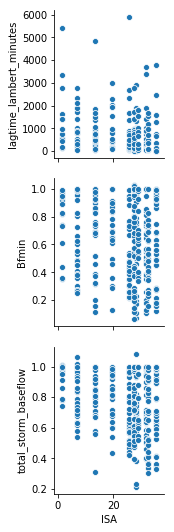

In [13]:
axs = sns.pairplot(untransformed, x_vars=['ISA'],
                   y_vars=['lagtime_lambert_minutes', 'Bfmin', 'total_storm_baseflow'])

50 57
<10 >10 and <20 Ttest_indResult(statistic=1.5109379623260852, pvalue=0.13380798469360417)
50 222
<10 >20 Ttest_indResult(statistic=3.7416355646694557, pvalue=0.00022333449884431565)
57 50
>10 and <20 <10 Ttest_indResult(statistic=-1.5109379623260852, pvalue=0.13380798469360417)
57 222
>10 and <20 >20 Ttest_indResult(statistic=2.3906504143234693, pvalue=0.017486619381871838)
222 50
>20 <10 Ttest_indResult(statistic=-3.7416355646694557, pvalue=0.00022333449884431565)
222 57
>20 >10 and <20 Ttest_indResult(statistic=-2.3906504143234693, pvalue=0.017486619381871838)


/Users/estorrs/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/estorrs/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


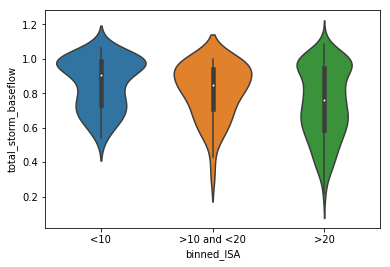

In [14]:
plotting_df = untransformed[['ISA', 'total_storm_baseflow']]

def bin_total_storm_baseflow(n):
    if n > .8:
        return 'high'
    elif n > .5:
        return 'medium'
    elif n > 0:
        return 'low'
    
    return np.nan

def bin_ISA(n):
    if n > 20:
        return '>20'
    elif n > 10:
        return '>10 and <20'
    elif n > 0:
        return '<10'
    
    return np.nan

plotting_df['binned_total_storm_baseflow'] = [bin_total_storm_baseflow(n)
                                              for n in plotting_df['total_storm_baseflow']]
plotting_df['binned_ISA'] = [bin_ISA(n)
                            for n in plotting_df['ISA']]
ax = sns.violinplot(x="binned_ISA", y="total_storm_baseflow", data=plotting_df,
                   order=['<10', '>10 and <20', '>20'])

for x in ['<10', '>10 and <20', '>20']:
    for y in ['<10', '>10 and <20', '>20']:
        if x != y:
            ls = plotting_df[plotting_df['binned_ISA']==x]['total_storm_baseflow']
            xs = plotting_df[plotting_df['binned_ISA']==y]['total_storm_baseflow']
            print(len(ls), len(xs))
            print(x, y, scipy.stats.ttest_ind(ls, xs))

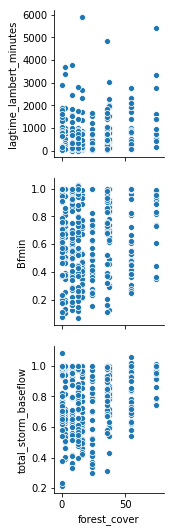

In [15]:
axs = sns.pairplot(untransformed, x_vars=['forest_cover'],
                   y_vars=['lagtime_lambert_minutes', 'Bfmin', 'total_storm_baseflow'])

(-1e-06, 1e-06)

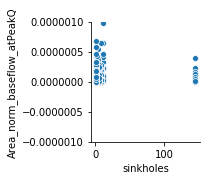

In [16]:
axs = sns.pairplot(untransformed, x_vars=['sinkholes'],
                   y_vars=['Area_norm_baseflow_atPeakQ'])

plt.ylim(-.000001, .000001)

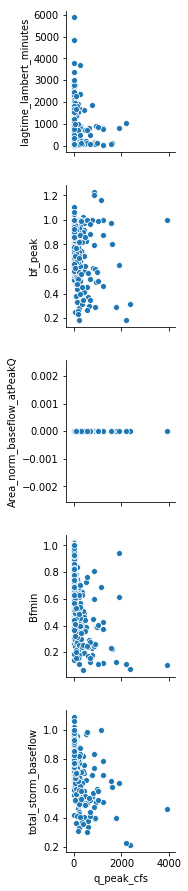

In [17]:
axs = sns.pairplot(untransformed, x_vars=['q_peak_cfs'], 
                   y_vars=['lagtime_lambert_minutes', 'bf_peak', 'Area_norm_baseflow_atPeakQ',
                           'Bfmin', 'total_storm_baseflow'])

In [18]:
plotting_df.head()

,ISA,total_storm_baseflow,binned_total_storm_baseflow,binned_ISA
0,31.95,0.393710,low,>20
1,31.95,0.901377,high,>20
2,31.95,0.859293,high,>20
3,31.95,0.993589,high,>20
4,31.95,0.670580,medium,>20


/Users/estorrs/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/estorrs/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/estorrs/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)


1 84
winter spring Ttest_indResult(statistic=nan, pvalue=nan)
1 168
winter summer Ttest_indResult(statistic=nan, pvalue=nan)
1 76
winter fall Ttest_indResult(statistic=nan, pvalue=nan)
84 1
spring winter Ttest_indResult(statistic=nan, pvalue=nan)
84 168
spring summer Ttest_indResult(statistic=nan, pvalue=nan)
84 76
spring fall Ttest_indResult(statistic=nan, pvalue=nan)
168 1
summer winter Ttest_indResult(statistic=nan, pvalue=nan)
168 84
summer spring Ttest_indResult(statistic=nan, pvalue=nan)
168 76
summer fall Ttest_indResult(statistic=nan, pvalue=nan)
76 1
fall winter Ttest_indResult(statistic=nan, pvalue=nan)
76 84
fall spring Ttest_indResult(statistic=nan, pvalue=nan)
76 168
fall summer Ttest_indResult(statistic=nan, pvalue=nan)


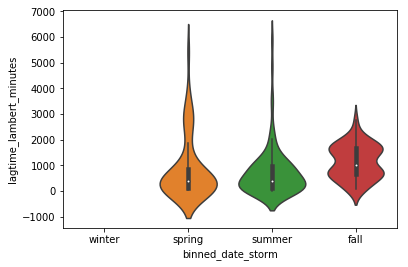

In [19]:
plotting_df = untransformed[['date_storm'] + dependent]
plotting_df['date_storm'] = [datetime_string_to_month(d) for d in plotting_df['date_storm']]


y_variable = 'lagtime_lambert_minutes'

def bin_date_storm(n):
    if n in [12.0, 1.0, 2.0]:
        return 'winter'
    elif n in [3.0, 4.0, 5.0]:
        return 'spring'
    elif n in [6.0, 7.0, 8.0]:
        return 'summer'
    elif n in [9.0, 10.0, 11.0]:
        return 'fall'
    
    return np.nan

plotting_df['binned_date_storm'] = [bin_date_storm(n)
                            for n in plotting_df['date_storm']]
ax = sns.violinplot(x="binned_date_storm", y=y_variable, data=plotting_df,
                   order=['winter', 'spring', 'summer', 'fall'])

for x in ['winter', 'spring', 'summer', 'fall']:
    for y in ['winter', 'spring', 'summer', 'fall']:
        if x != y:
            ls = plotting_df[plotting_df['binned_date_storm']==x][y_variable]
            xs = plotting_df[plotting_df['binned_date_storm']==y][y_variable]
            print(len(ls), len(xs))
            print(x, y, scipy.stats.ttest_ind(ls, xs))

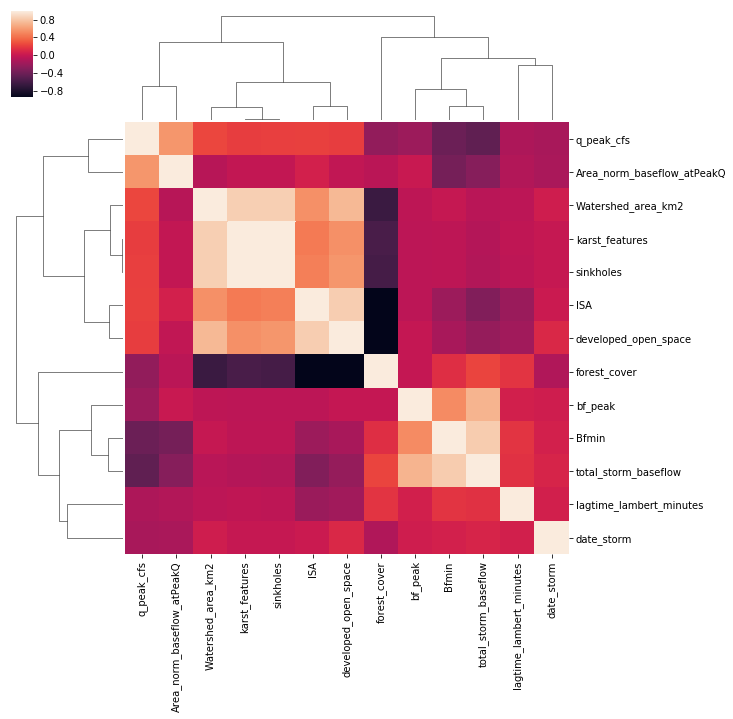

In [20]:
axs = sns.clustermap(df.corr())